# Food Security

<p>
The Food and Agriculture Organization of the United Nations (FAO) State of Food Insecurity for 2010 assesses that nearly 1 billion people are estimated to be undernourished, representing almost 16 percent of the population of developing countries.
<p>
<p>
Although there has been strong commitment of international institutions and the efforts conducted to reach the objective to half, within the past years, the number of people suffering from hunger, food insecurity still represents one of the biggest challenges for a big part of the world population and must be treated with the utmost urgency.
<p>
<p>
It is generally recognized that food security, and therefore food insecurity, is a multidimensional phenomenon. A number of indices have been designed to provide a basis for understanding food insecurity scenario. However, none of these indexes reach to capture all aspects of food insecurity, as stated by the Scientific Symposium on Measurement and Assessment of Food
Deprivation and Undernutrition in 2002 and there are rarely any attempts to establish an objective method for clustering geographic regions by either their vulnerability to food insecurity or their potential as resilient zones in the face of various climatic and socio-economic pressures
<p>
<p>
The lack of a commonly accepted,comprehensive measure for food security on an international scale has been identified as one of the roadblocks on the way to the eradication of hunger and malnutrition. A suite of indicators is therefore needed to cover the different dimensions of food security: 
    
1. Availability.
2. Access.
3. Utilization.
4. Stability.
    
This notebook adopts a machine learning algorithm to generate geographical clusters that provides the grounds of making evidence-driven policy to aid achieve a food secure country.
<p>

## Load libraries and Data

In [1]:
# Import relevant libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from esda.moran import Moran
import libpysal.weights.set_operations as Wsets
from libpysal.weights import Queen, KNN, Rook
from sklearn.cluster import KMeans, AgglomerativeClustering

# supress warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
#load data
file_name = "data/Counties_food_security.shp"
fs_df = gpd.read_file(file_name)


In [3]:
#Change data type for column 'Code' and make it the index column
fs_df.set_index(fs_df.Code.astype(int),inplace=True)
fs_df.sort_index(inplace=True)

In [4]:
# Rename columns
new_columns_name = {'Severe_stu':'Severe stunting in children (%)',
          'Severe_was':'Severe wasting in children (%)',
       'Severe_und':'Severe underweight (%)', 
        'Food_pover':'Food poverty rate (%)', 
        'Poor_Feedi':'Poor_Feeding_Score',
        'Borderline':'Borderline_feeding_score', 
        'Unacceptab':'Unacceptable_Feeding_Score',
       'Maize_Prod':'Maize_Production(Ton)', 
        'Beans_Prod':'Beans_Production(Ton)',
        'TLU':'Tropical Livestock Unit', 
        'Land_Area_':'Land Area (Km2)',
        'Arable_Lan':'Arable Land (Km2)',
       'Arable_L_1':'Arable Land (%)',
        'Rural_Popu':'Rural_Population', 
        'Urban_Popu':'Urban_Population',
        'Total_Popu':'Total Population', 
        'Population':'Population_Density/sqKm',
       'Male_Liter':'Male Literacy',
        'Female_Lit':'Female Literacy',
        'Overall_Li':'Overall Literacy',
        'poverty_ra':'poverty_rate_percentage',
        'GCP_USD':'GCP_USD',
       'Mean_dista':'Mean_distance_to_roads',
        'Conflict_c':'Conflict_cases_per_year',
        'Food_Sourc':'Food_Source_Purchases', 
        'Food_Sou_1':'Food_Source_Stock', 
        'Food_Sou_2':'Food_Source_Own_production',
       'Food_sou_3':'Food_source_Gifts',
        'Access_imp':'Access_improved Sanitation services',
        'Access_to_':'Access to Water',
        'Access_to1':'Access to_Unimproved Sanitation Services',
        'Average_Ra':'Average Rainfall',
       'Evapotrans':'Evapotransipiration',
          }

fs_df.rename(columns=new_columns_name, inplace=True)

In [5]:
# Print df shape
fs_df.shape

(47, 37)

In [6]:
# Print new columns names
fs_df.columns

Index(['COUNTY', 'Code', 'Severe stunting in children (%)',
       'Severe wasting in children (%)', 'Severe underweight (%)',
       'Food poverty rate (%)', 'Poor_Feeding_Score',
       'Borderline_feeding_score', 'Unacceptable_Feeding_Score',
       'Maize_Production(Ton)', 'Beans_Production(Ton)',
       'Tropical Livestock Unit', 'Land Area (Km2)', 'Arable Land (Km2)',
       'Arable Land (%)', 'Rural_Population', 'Urban_Population',
       'Total Population', 'Population_Density/sqKm', 'Male Literacy',
       'Female Literacy', 'Overall Literacy', 'poverty_rate_percentage',
       'GCP_USD', 'Mean_distance_to_roads', 'Conflict_cases_per_year',
       'Food_Source_Purchases', 'Food_Source_Stock',
       'Food_Source_Own_production', 'Food_source_Gifts',
       'Access_improved Sanitation services', 'Access to Water',
       'Access to_Unimproved Sanitation Services', 'Average Rainfall',
       'Evapotransipiration', 'ObjectID', 'geometry'],
      dtype='object')

In [7]:
# Print the first five columns of the data frame
fs_df.head()

,COUNTY,Code,Severe stunting in children (%),Severe wasting in children (%),Severe underweight (%),Food poverty rate (%),Poor_Feeding_Score,Borderline_feeding_score,Unacceptable_Feeding_Score,Maize_Production(Ton),...,Food_Source_Stock,Food_Source_Own_production,Food_source_Gifts,Access_improved Sanitation services,Access to Water,Access to_Unimproved Sanitation Services,Average Rainfall,Evapotransipiration,ObjectID,geometry
Code,,,,,,,,,,,,,,,,,,,,,
1,Mombasa,1.0,11.9,2.5,2.6,2.2,1.0,7.0,8.0,309.0,...,7.5,0.4,3.0,86.3,44.2,27.2,1184.868526,0.651168,28,"MULTIPOLYGON (((39.58429 -4.11780, 39.57849 -4..."
2,Kwale,2.0,13.9,2.5,0.4,5.9,2.0,18.0,20.0,62103.0,...,4.8,20.7,3.6,33.7,82.7,44.7,876.933624,0.536560,19,"MULTIPOLYGON (((39.40649 -4.70221, 39.40588 -4..."
3,Kilifi,3.0,10.8,1.4,1.3,7.0,1.0,12.0,13.0,54675.0,...,7.5,15.5,7.0,70.0,65.9,1.6,822.434090,0.480857,14,"MULTIPOLYGON (((39.96851 -3.39301, 39.96808 -3..."
4,Tana River,4.0,11.4,6.0,1.6,17.9,5.0,15.0,20.0,3536.0,...,4.7,9.0,5.1,60.6,74.9,38.3,563.185214,0.291208,40,"POLYGON ((38.76868 -0.06875, 38.77035 -0.06899..."
5,Lamu,5.0,10.5,4.3,1.5,3.2,0.0,8.0,8.0,29025.0,...,6.0,13.2,4.6,70.0,67.8,34.4,812.305999,0.468851,21,"MULTIPOLYGON (((40.71307 -2.29510, 40.71350 -2..."


In [8]:
# Print the last five columns of the data frame
fs_df.sample(5)

,COUNTY,Code,Severe stunting in children (%),Severe wasting in children (%),Severe underweight (%),Food poverty rate (%),Poor_Feeding_Score,Borderline_feeding_score,Unacceptable_Feeding_Score,Maize_Production(Ton),...,Food_Source_Stock,Food_Source_Own_production,Food_source_Gifts,Access_improved Sanitation services,Access to Water,Access to_Unimproved Sanitation Services,Average Rainfall,Evapotransipiration,ObjectID,geometry
Code,,,,,,,,,,,,,,,,,,,,,
17,Makueni,17.0,6.6,1.8,0.8,6.6,2.0,6.0,9.0,62759.0,...,5.7,30.4,3.1,88.0,63.3,68.0,741.905067,0.384672,23,"POLYGON ((37.54930 -1.53775, 37.55000 -1.53811..."
47,Nairobi,47.0,11.8,1.6,1.8,0.6,2.0,8.0,10.0,457.0,...,9.2,1.6,2.6,91.9,48.4,28.6,833.709756,0.502875,30,"POLYGON ((37.10272 -1.26172, 37.10276 -1.26197..."
4,Tana River,4.0,11.4,6.0,1.6,17.9,5.0,15.0,20.0,3536.0,...,4.7,9.0,5.1,60.6,74.9,38.3,563.185214,0.291208,40,"POLYGON ((38.76868 -0.06875, 38.77035 -0.06899..."
23,Turkana,23.0,7.8,4.7,15.9,52.7,19.0,24.0,43.0,3741.0,...,13.8,7.0,16.0,31.9,33.9,74.9,359.476373,0.194082,43,"POLYGON ((35.79593 5.34449, 35.79659 5.34468, ..."
6,Taita Taveta,6.0,10.4,0.8,1.9,5.3,2.0,12.0,14.0,20365.0,...,8.8,22.1,5.5,98.8,75.7,60.7,697.103282,0.421945,39,"POLYGON ((38.54604 -2.97978, 38.54692 -2.97989..."


In [9]:
fs_df.describe()

,Code,Severe stunting in children (%),Severe wasting in children (%),Severe underweight (%),Food poverty rate (%),Poor_Feeding_Score,Borderline_feeding_score,Unacceptable_Feeding_Score,Maize_Production(Ton),Beans_Production(Ton),...,Food_Source_Purchases,Food_Source_Stock,Food_Source_Own_production,Food_source_Gifts,Access_improved Sanitation services,Access to Water,Access to_Unimproved Sanitation Services,Average Rainfall,Evapotransipiration,ObjectID
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,...,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,24.000000,11.308511,3.070213,3.117021,10.644681,2.212766,10.787234,13.170213,84324.531915,16297.361702,...,64.134043,9.304255,20.653191,5.859574,59.119149,65.329787,40.874468,1026.693364,0.597710,24.000000
std,13.711309,3.642015,2.909872,3.983680,11.091160,2.873690,5.225091,7.111898,109516.388380,18278.600955,...,11.254956,6.632888,9.536015,3.082677,24.412039,17.932578,24.389105,417.020621,0.261364,13.711309
min,1.000000,3.000000,0.000000,0.000000,0.200000,0.000000,2.000000,3.000000,0.000000,0.000000,...,38.000000,2.200000,0.400000,1.900000,6.200000,27.800000,1.300000,314.380546,0.133693,1.000000
25%,12.500000,8.400000,1.050000,0.750000,3.850000,1.000000,7.500000,9.000000,19746.500000,251.000000,...,57.150000,5.950000,13.300000,4.000000,39.850000,53.150000,17.550000,732.168188,0.422925,12.500000
50%,24.000000,11.100000,2.100000,1.600000,7.000000,2.000000,10.000000,12.000000,54675.000000,10827.000000,...,61.900000,8.200000,21.500000,5.100000,60.600000,67.200000,39.300000,1011.279505,0.631576,24.000000
75%,35.500000,13.600000,4.500000,2.900000,11.750000,3.000000,13.000000,15.500000,91821.000000,26643.500000,...,70.450000,10.400000,28.550000,6.800000,82.500000,79.850000,60.150000,1339.134350,0.822180,35.500000
max,47.000000,18.500000,11.900000,16.600000,52.700000,19.000000,24.000000,43.000000,548197.000000,83945.000000,...,88.900000,47.200000,38.100000,17.000000,98.800000,97.100000,93.700000,1857.249231,1.024794,47.000000


# Multivariate Analysis



# Food Security Indicator Categorization

<center><h2><u>Proxy Food Security Indicators</u></h2></center>
 

| Dimensions   | Food Security Indicators   |
| ------  | ------ |
| Availability| Bean Production(Ton)|
| |Maize production(Ton)|
| | Tropical Livestock Unit|
| | Arable Land (Km2)|
| |Arable Land (%)|
| | Average Rainfall|
| | Evapotransipiration|
|Accessibility|poverty_rate_percentage|
| | Conflict_cases_per_year|
| | Mean_distance_to_roads|
| | GCP_USD|
| | Rural_Population|
| | Urban_Population|
| | Total Population|
| | Population_Density/sqKm|
| Utilization| Severe stunting in children(%)|
| | Severe wasting in children (%)|
| | Severe underweight (%)|
| | Male Literacy|
| | Female Literacy|
| | Overall Literacy|
| | Access_improved Sanitation services|
| | Access to_Unimproved Sanitation Services|
| | Food poverty rate (%)|
| |Poor_Feeding_Score|
| | Borderline_feeding_score|
| | Unacceptable_Feeding_Score|
|Stability|Food source purchase|
| | Food_Source_Purchases|
| | Food_Source_Stock|
| | Food_Source_Own_production|



In [10]:
#Food Security feature selection
availability=[
            'Beans_Production(Ton)',
              'Maize_Production(Ton)',
              'Tropical Livestock Unit',
              'Arable Land (Km2)',
               'Arable Land (%)',
              'Average Rainfall',
              'Evapotransipiration'
]
accessibility = [
                'poverty_rate_percentage',
                 'Conflict_cases_per_year',
                 'Mean_distance_to_roads',
#             'Rural_Population',
                    'GCP_USD',
#              'Urban_Population',
#                  'Total Population',
             'Population_Density/sqKm',
]
utilization = [
              'Severe stunting in children (%)',
               'Severe wasting in children (%)', 
               'Severe underweight (%)',
               'Male Literacy',
               'Female Literacy', 
#                'Overall Literacy',
               'Access_improved Sanitation services', 
               'Access to Water',
               'Access to_Unimproved Sanitation Services',
               'Food poverty rate (%)', 
               'Poor_Feeding_Score',
               'Borderline_feeding_score',
               'Unacceptable_Feeding_Score'
]
stability = [

             'Food_Source_Purchases',
             'Food_Source_Stock',
             'Food_Source_Own_production',
            'Food_source_Gifts'
]

#                             Food Security dimensions 


### Availability

In [11]:
# Availability variables
availability_df = fs_df[availability]
availability_df.head()

,Beans_Production(Ton),Maize_Production(Ton),Tropical Livestock Unit,Arable Land (Km2),Arable Land (%),Average Rainfall,Evapotransipiration
Code,,,,,,,
1,0.0,309.0,14708.740,167.858892,74.273846,1184.868526,0.651168
2,71.0,62103.0,412617.000,3411.076602,41.381495,876.933624,0.536560
3,21.0,54675.0,1005388.760,5389.473138,43.115785,822.434090,0.480857
4,0.0,3536.0,824546.980,705.408480,1.865075,563.185214,0.291208
5,0.0,29025.0,149903.096,468.390802,7.590193,812.305999,0.468851


### Accesibility

In [12]:
# Accessibility variables
accessibility_df = fs_df[accessibility]
accessibility_df.head()

,poverty_rate_percentage,Conflict_cases_per_year,Mean_distance_to_roads,GCP_USD,Population_Density/sqKm
Code,,,,,
1,37.6,16.217391,3.533860,3321.22,5346.606195
2,72.9,3.217391,13.335895,862.78,105.158316
3,66.9,3.913043,19.340122,1192.95,116.302960
4,75.4,4.826087,66.472994,334.98,8.353419
5,30.6,6.347826,33.987982,323.86,23.321990


### Utilization

In [13]:
# Utilization variables
utilization_df = fs_df[utilization]
utilization_df.head()

,Severe stunting in children (%),Severe wasting in children (%),Severe underweight (%),Male Literacy,Female Literacy,Access_improved Sanitation services,Access to Water,Access to_Unimproved Sanitation Services,Food poverty rate (%),Poor_Feeding_Score,Borderline_feeding_score,Unacceptable_Feeding_Score
Code,,,,,,,,,,,,
1,11.9,2.5,2.6,96.1,93.2,86.3,44.2,27.2,2.2,1.0,7.0,8.0
2,13.9,2.5,0.4,79.9,55.7,33.7,82.7,44.7,5.9,2.0,18.0,20.0
3,10.8,1.4,1.3,90.7,70.4,70.0,65.9,1.6,7.0,1.0,12.0,13.0
4,11.4,6.0,1.6,78.8,58.2,60.6,74.9,38.3,17.9,5.0,15.0,20.0
5,10.5,4.3,1.5,87.3,77.3,70.0,67.8,34.4,3.2,0.0,8.0,8.0


### Stability

In [14]:
# Stability Variables
stability_df=fs_df[stability]
stability_df.head()

,Food_Source_Purchases,Food_Source_Stock,Food_Source_Own_production,Food_source_Gifts
Code,,,,
1,88.9,7.5,0.4,3.0
2,70.9,4.8,20.7,3.6
3,70.0,7.5,15.5,7.0
4,81.1,4.7,9.0,5.1
5,76.3,6.0,13.2,4.6


# Dimensionality Reduction 
### Principal Component Analysis

##### Availability

In [15]:
# Separating out the features
x = availability_df.loc[:, availability].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# PCA Analysis
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalComponents

fs_df["availability"]=principalComponents

fs_df.availability=fs_df.availability.map(lambda p:p*-1)
fs_df[['COUNTY','availability']].sample(10)

,COUNTY,availability
Code,,
43,Homa Bay,0.443411
28,Keiyo-Marakwet,0.749628
40,Busia,1.450556
38,Vihiga,2.325569
2,Kwale,-0.673179
46,Nyamira,2.682548
5,Lamu,-1.399766
8,Wajir,-3.601257
33,Narok,-0.231131


##### accessibility

In [16]:
x = accessibility_df.loc[:, accessibility].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# PCA Analysis
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalComponents

fs_df["accessibility"]=principalComponents
fs_df[['COUNTY','accessibility']].sample(10)

,COUNTY,accessibility
Code,,
11,Isiolo,-0.770067
45,Kisii,0.113138
16,Machakos,-0.158761
19,Nyeri,0.326475
23,Turkana,-0.952741
47,Nairobi,9.723556
18,Nyandarua,0.039947
14,Embu,-0.286159
20,Kirinyaga,0.093281


##### utilization

In [17]:
x = utilization_df.loc[:, utilization].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# PCA Analysis
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalComponents

fs_df["utilization"]=principalComponents
fs_df.utilization=fs_df.utilization.map(lambda p:p*-1)

fs_df[['COUNTY','utilization']].sample(10)

,COUNTY,utilization
Code,,
35,Kericho,1.530180
16,Machakos,1.926969
22,Kiambu,1.956424
26,Trans Nzoia,0.398011
33,Narok,-0.049575
29,Nandi,0.822133
20,Kirinyaga,2.518621
10,Marsabit,-4.236629
12,Meru,0.426625


##### stability

In [18]:
x = stability_df.loc[:, stability].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# PCA Analysis
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
fs_df["stability"]=principalComponents
fs_df[['COUNTY','stability']].sample(10)

,COUNTY,stability
Code,,
17,Makueni,-0.317392
4,Tana River,2.040348
9,Mandera,1.118450
22,Kiambu,2.572805
10,Marsabit,0.346732
16,Machakos,1.309909
13,Tharaka,-2.030274
47,Nairobi,2.918346
28,Keiyo-Marakwet,-1.834789


### Food Security Dimension Visualizations

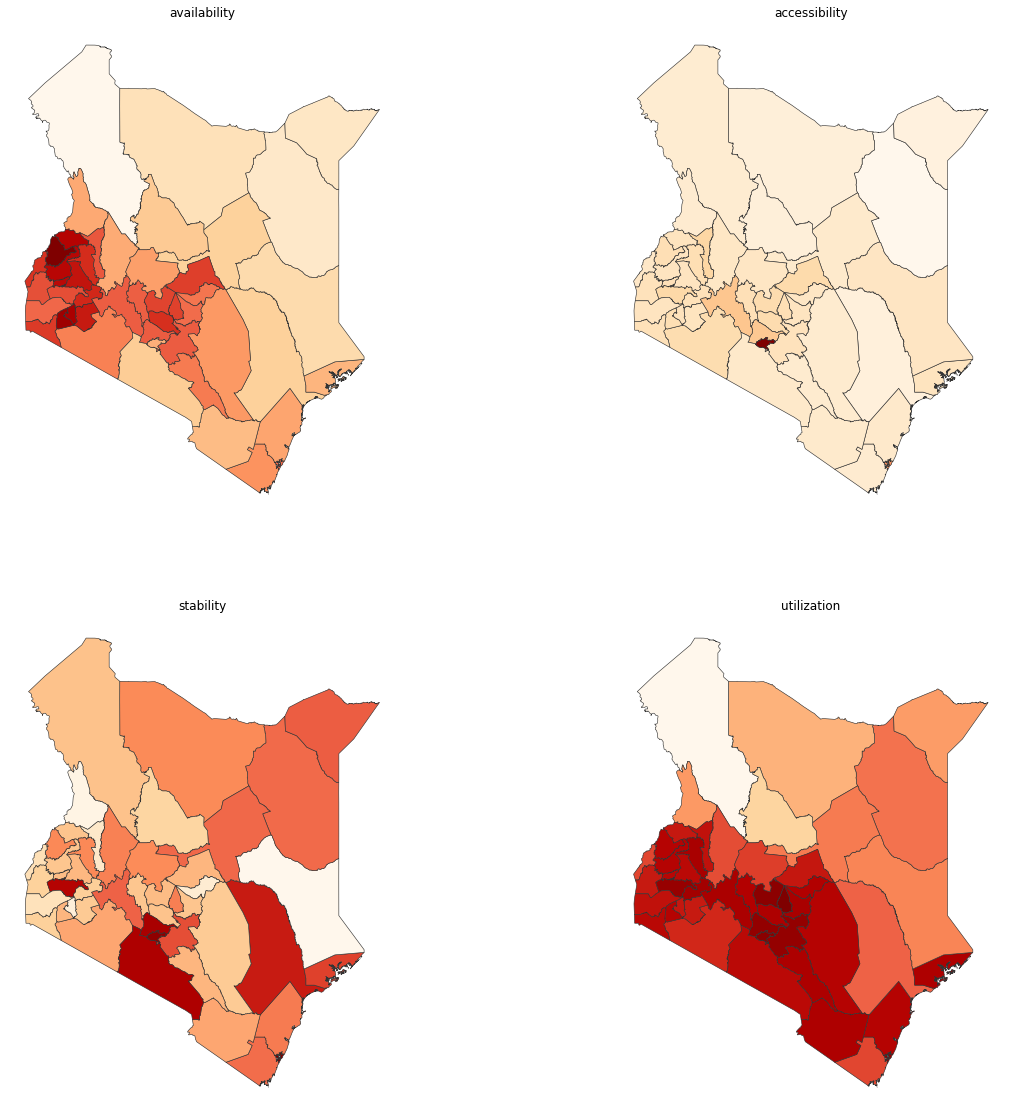

In [19]:
fs_dimensions=["availability","accessibility","stability","utilization"]
# fs_df[fs_dimensions]
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(fs_dimensions):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    fs_df.plot(column=col, cmap='OrRd', linewidth=.6, edgecolor='0.2',
          ax=ax)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

## Spatial Autocorrelation

In [20]:
# Genereate a spatial weights matrix
w = KNN.from_dataframe(fs_df[["availability","accessibility","stability","utilization","geometry"]],k=5)
w.islands

[]

In [21]:
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [Moran(fs_df[variable], w) for variable in fs_dimensions]
# Display on table
table = pd.DataFrame([(variable, res.I, res.p_sim) \
                          for variable,res \
                          in zip(fs_dimensions, mi_results)
                         ], columns=['Variable', "Moran's I", 'P-value']
                        )\
              .set_index('Variable')
table

,Moran's I,P-value
Variable,,
availability,0.560545,0.001
accessibility,0.057052,0.103
stability,0.132945,0.047
utilization,0.450717,0.001


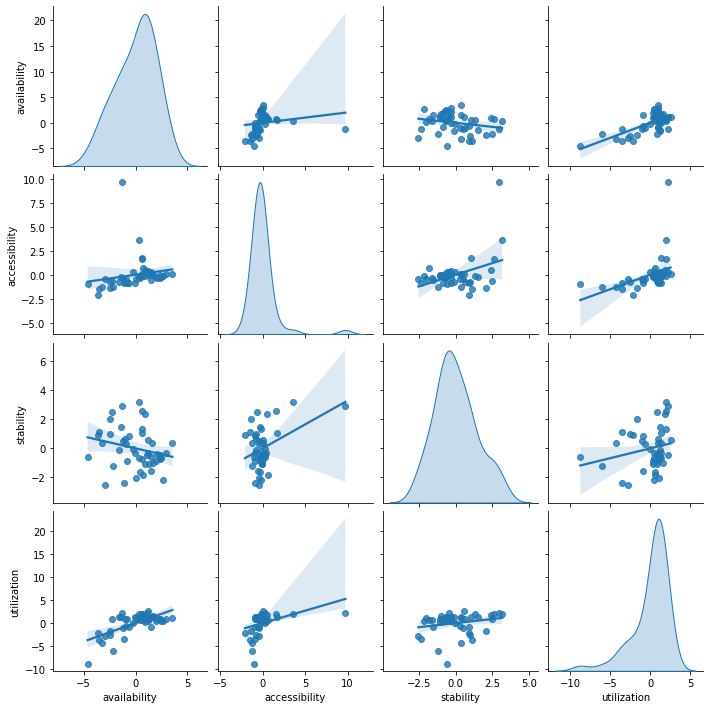

In [22]:
_ = seaborn.pairplot( fs_df[fs_dimensions], kind='reg', diag_kind='kde')

# CLustering and Regionalization

<p>
Clustering is a fundamental method of geographical analysis that draws insights from large complex multivariate processes. It works by finding similarities among the many dimensions in a multivariate process, condensing them down into a simpler representation. Oftenly, clustering involves sorting observations into groups called clusters. The process of creating clusters is called clustering. For these clusters to be statistically significant than any single initial dimension, members of each cluster chould be more similar to one another than they are to members of a different group.
<p>
    
<p>
A region is similar to a cluster, in the sense that all members of a region have been grouped together. For a region to be statistically significant, its members should display stronger similarity to each other and also should be geographically connected. The process of creating regions is called regionalizations. A regionalization is a special kind of clustering where the objective is to group observations which are similar in their statistical attributes, but also in their spatial location. The geographical constraints is based on connectivity, i.e two candidates can only be grouped together in the same region if there exists a path from one member to another member that never leaves the region
<p>

# kmeans clustering
K-means is probably the most widely used approach to cluster a dataset. The algorithm groups observations into a pre-specified number of clusters so that that each observation is closer to the mean of its own cluster than it is to the mean of any other cluster. The k-means problem is solved by iterating between an assignment step and an update step. First, all observations are randomly assigned one of the k labels. Next, the multivariate mean over all covariates is calculated for each of the clusters. Then, each observation is reassigned to the cluster with the closest mean. If the observation is already assigned to the cluster whose mean it is closest to, the observation remains in that cluster. This assignment-update process continues until no further reassignments are necessary.

In [23]:
# Initialise KMeans instance
kmeans = KMeans(n_clusters=5)
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(fs_df[fs_dimensions])


In [24]:
# Examine the label vectors which contains the cluster tow which each observation is assigned
k5cls.labels_

array([4, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 0, 0, 0, 3, 4, 3, 0, 0, 4, 0, 4,
       1, 1, 1, 0, 0, 0, 0, 3, 3, 4, 3, 3, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
       0, 0, 2])

### Spatial Distribution of clusters

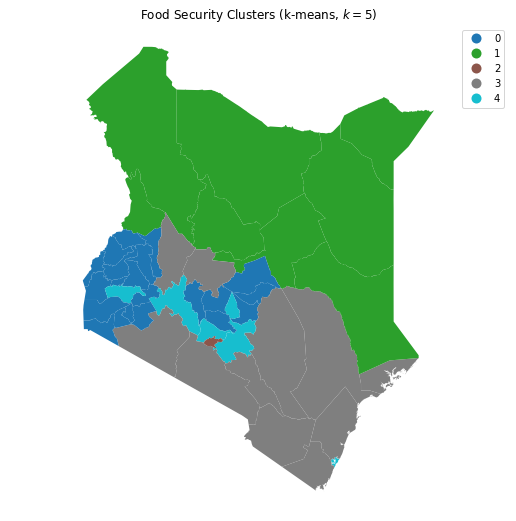

In [25]:
# Assign labels into a column
fs_df['k5cls'] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
fs_df.plot(column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Food Security Clusters (k-means, $k=5$)')
# Display the map
plt.show()

### Statistical Analysis of the cluster map

In [26]:
# Group data table by cluster label and count observations
k5sizes = fs_df.groupby('k5cls').size()
k5sizes

k5cls
0    21
1     8
2     1
3    11
4     6
dtype: int64

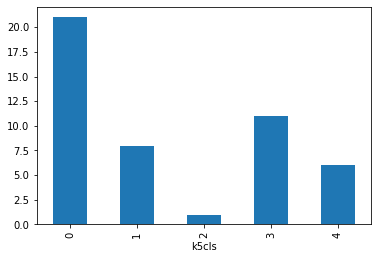

In [27]:
_ = k5sizes.plot.bar()

#### Cluster profile

In [28]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their mean
k5means = fs_df.groupby('k5cls')[fs_dimensions].mean()
k5means.T.round(3)

k5cls,0,1,2,3,4
availability,1.590,-2.972,-1.285,-1.155,0.729
accessibility,-0.050,-1.136,9.724,-0.638,1.237
stability,-0.837,-0.417,2.918,0.635,1.836
utilization,0.843,-4.197,2.180,0.197,1.921


In [29]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their descriptive summary
k5desc = fs_df.groupby('k5cls')[fs_dimensions].describe()
# Loop over each cluster and print a table with descriptives
for cluster in k5desc.T:
    print('\n\t---------\n\tCluster %i'%cluster)
    print(k5desc.T[cluster].unstack())


	---------
	Cluster 0
               count      mean       std       min       25%       50%  \
availability    21.0  1.589601  0.923950  0.083303  0.889957  1.540346   
accessibility   21.0 -0.049601  0.301360 -0.538912 -0.286159 -0.069663   
stability       21.0 -0.837381  0.688829 -2.148392 -1.064790 -0.705734   
utilization     21.0  0.842849  0.601728 -0.892695  0.445100  0.917749   

                    75%       max  
availability   2.325569  3.553983  
accessibility  0.105309  0.682526  
stability     -0.444411  0.384250  
utilization    1.122422  2.154234  

	---------
	Cluster 1
               count      mean       std       min       25%       50%  \
availability     8.0 -2.971527  1.043768 -4.621720 -3.550119 -3.084784   
accessibility    8.0 -1.135569  0.507618 -2.068772 -1.328065 -1.103588   
stability        8.0 -0.417484  1.492251 -2.543191 -1.480839 -0.123522   
utilization      8.0 -4.196746  2.198313 -8.755335 -4.679516 -3.540110   

                    75%       ma

In [30]:
# Index db on cluster ID
tidy_db = fs_df.set_index('k5cls')
# Keep only variables used for clustering
tidy_db = tidy_db[fs_dimensions]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_db.head()

,k5cls,Attribute,Values
0,4,availability,0.330930
1,4,accessibility,3.616748
2,4,stability,3.155401
3,4,utilization,1.992673
4,3,availability,-0.673179


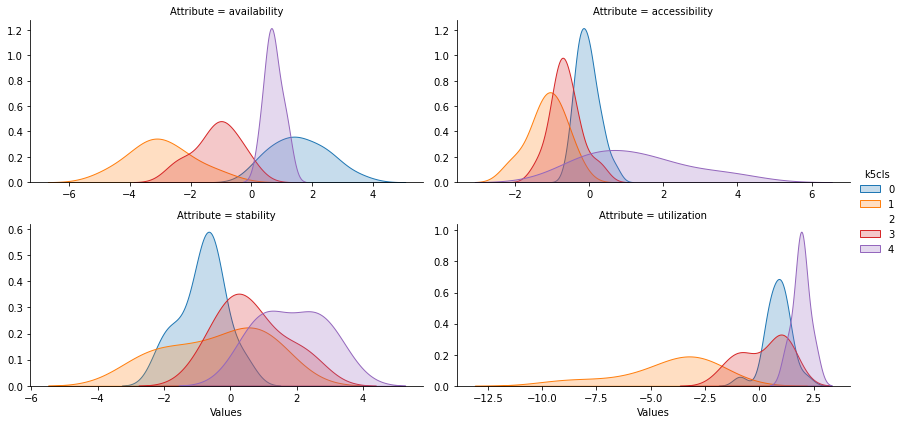

In [31]:
# Setup the facets
facets = seaborn.FacetGrid(data=tidy_db, col='Attribute', hue='k5cls', \
                  sharey=False, sharex=False, aspect=2, col_wrap=2)
# Build the plot from `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, 'Values', shade=True).add_legend()

## Hierarchical Clustering
### Agglomerative Hierarchical Clustering (AHC)
Agglomerative clustering works by building a hierarchy of clustering solutions that starts with all singletons (each observation is a single cluster in itself) and ends with all observations assigned to the same cluster. These extremes are not very useful in themselves. But, in between, the hierarchy contains many distinct clustering solutions with varying levels of detail. The intuition behind the algorithm is also rather straightforward:

1. Begin with everyone as part of its own cluster;

2. find the two closest observations based on a distance metric (e.g. euclidean);

3. join them into a new cluster;

4. repeat steps 2) and 3) until reaching the degree of aggregation desired.

The algorithm is thus called “agglomerative” because it starts with individual clusters and “agglomerates” them into fewer and fewer clusters containing more and more observations each. Also, like with k-means, AHC does require the user to specify a number of clusters in advance. This is because, following from the mechanism the method has to build clusters, AHC can provide a solution with as many clusters as observations (k=n), or with a only one (k=1).

In [32]:
# Set seed for reproducibility
np.random.seed(0)
# Iniciate the algorithm
model = AgglomerativeClustering(linkage='ward', n_clusters=5)
# Run clustering
model.fit(fs_df[fs_dimensions])
# Assign labels to main data table
fs_df['ward5'] =model.labels_

In [33]:
ward5sizes = fs_df.groupby('ward5').size()
ward5sizes

ward5
0     9
1    23
2     1
3    10
4     4
dtype: int64

In [34]:
ward5means = fs_df.groupby('ward5')[fs_dimensions].mean()
ward5means.T.round(3)

ward5,0,1,2,3,4
availability,-2.916,1.531,-1.285,-1.023,0.638
accessibility,-1.160,-0.048,9.724,-0.567,1.872
stability,-0.144,-0.683,2.918,0.495,2.287
utilization,-3.912,0.963,2.180,0.381,1.769


In [35]:
# Index db on cluster ID
tidy_db =fs_df.set_index('ward5')
# Keep only variables used for clustering
tidy_db = tidy_db[fs_dimensions]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_db.head()

,ward5,Attribute,Values
0,4,availability,0.330930
1,4,accessibility,3.616748
2,4,stability,3.155401
3,4,utilization,1.992673
4,3,availability,-0.673179


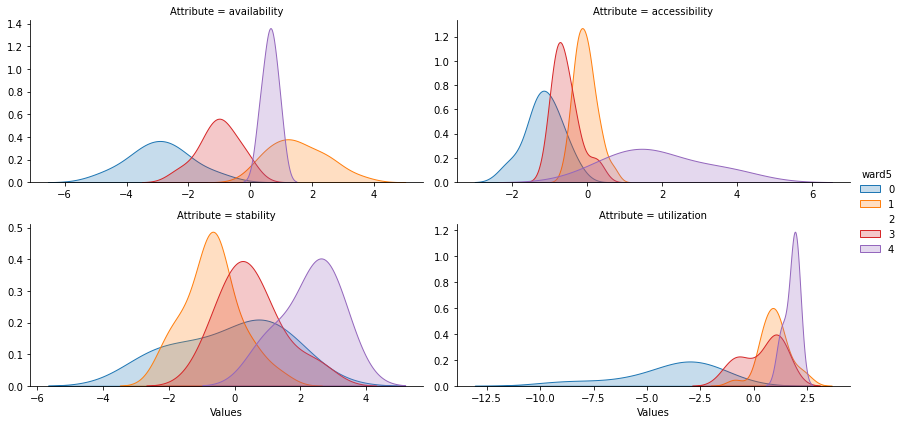

In [36]:
# Setup the facets
facets = seaborn.FacetGrid(data=tidy_db, col='Attribute', hue='ward5', \
                  sharey=False, sharex=False, aspect=2, col_wrap=2)
# Build the plot as a `sns.kdeplot`
_ = facets.map(seaborn.kdeplot, 'Values', shade=True).add_legend()

### Spatial Distribution of clusters

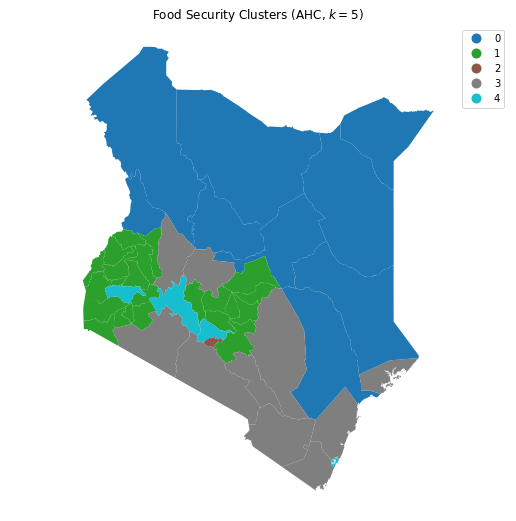

In [37]:
fs_df['ward5'] =model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
fs_df.plot(column='ward5', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title('Food Security Clusters (AHC, $k=5$)')
# Display the map
plt.show()

### K-means clustering Versus AHC clustering

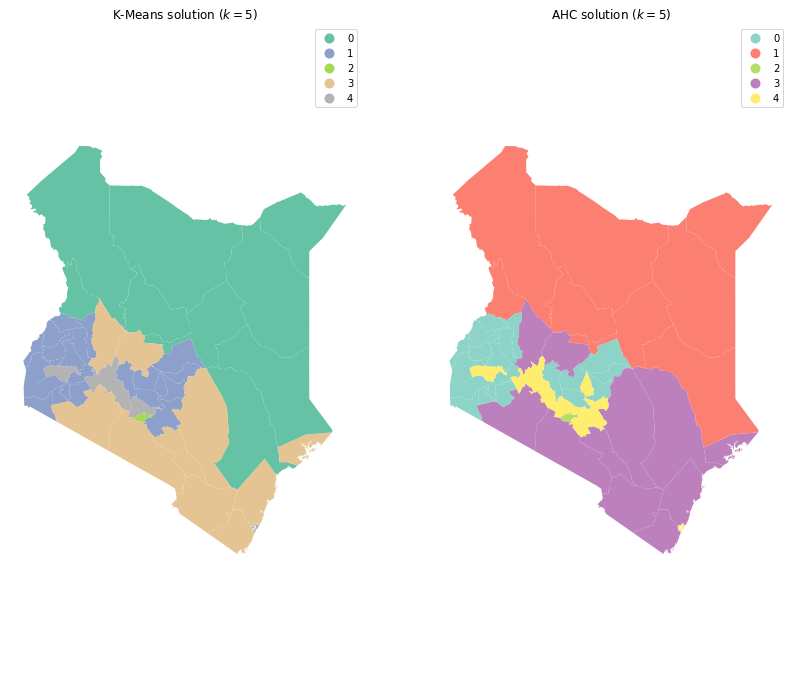

In [38]:
fs_df['ward5'] =model.labels_
# Setup figure and ax
f, axs = plt.subplots(1, 2, figsize=(14, 12))

ax = axs[0]
# Plot unique values choropleth including a legend and with no boundary lines
fs_df.plot(column='ward5', categorical=True, cmap='Set2', 
        legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
ax.axis('equal')
# Add title
ax.set_title('K-Means solution ($k=5$)')

ax = axs[1]
# Plot unique values choropleth including a legend and with no boundary lines
fs_df.plot(column='k5cls', categorical=True, cmap='Set3',
        legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
ax.axis('equal')
# Add title
ax.set_title('AHC solution ($k=5$)')

# Display the map
plt.show()

### Spatially Constrained Hierarchical Clustering
### Regionalization

Regionalization methods are clustering techniques that impose a spatial constraints on clusters. In other words, the result of a regionalization algorithm contains clusters with areas that are geographically coherent, in addition to having coherent data profiles. Effectively, this means that regionalization methods construct clusters that are all internally-connected; these are the regions. Thus, a regions’ members must be geographically nested within the region’s boundaries.By setting the connectivity option to the spatial weights matrix forces the agglomerative algorithm to only allow observations to be grouped in a cluster if they are also spatially connected.

In [39]:
np.random.seed(123456)
model = AgglomerativeClustering(linkage='ward',
                                            connectivity=w.sparse,
                                            n_clusters=5)
model.fit(fs_df[fs_dimensions]);
fs_df['ward5wq'] = model.labels_

### Spatial Distribution of Regions

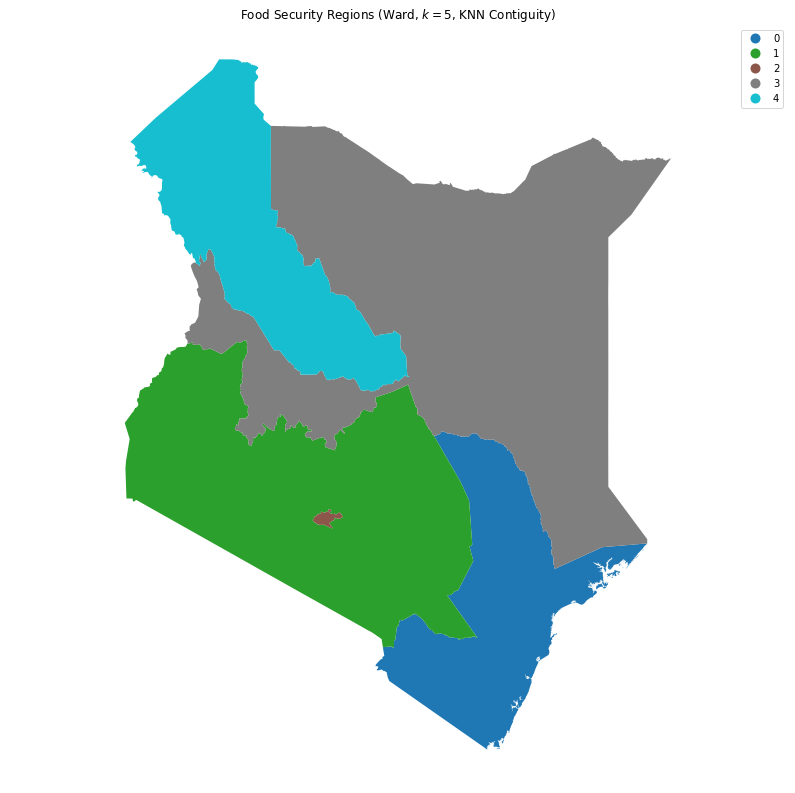

In [40]:
fs_regions = fs_df[['ward5wq','geometry']].dissolve(by='ward5wq')
f, ax = plt.subplots(1, figsize=(14, 14))
# plot the data 
fs_regions.reset_index().plot(column='ward5wq', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Food Security Regions (Ward, $k=5$, KNN Contiguity)')
# Display the map
plt.show()